In [9]:
import json
import pandas as pd
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
DATA_FILES = ['ITiCSE18.json', 'ITiCSE19.json', 'ITiCSE20.json']

In [4]:
# Load data
author_affiliations = {}
all_papers = []
for filename in DATA_FILES:
    with open(filename) as f:
        papers = json.load(f)
    for paper in papers:
        authors = []
        affiliations = []
        for author in paper['authors']:
            # TODO check if any author changed affiliations. Yep, that happens...
            name = author['name']
            affiliation = author['affiliation']
            author_affiliations[name] = affiliation
            authors.append(name)
            affiliations.append(affiliation)
        paper['authors'] = authors
        paper['affiliations'] = affiliations
        paper['venue'] = os.path.splitext(os.path.basename(filename))[0]
        all_papers.append(paper)
papers = pd.DataFrame(all_papers)
papers.head()

,title,link,abstract,authors,tags,affiliations,venue
0,Dancing rainbots: computing education with gir...,https://dl.acm.org/doi/10.1145/3197091.3211885,"We want women and girls to participate, thrive...",[Judy Robertson],"[barriers, inclusion, Women in computing]","[University of Edinburgh, UK]",ITiCSE18
1,A new era towards more engaging and human-like...,https://dl.acm.org/doi/10.1145/3197091.3211886,Engagement of learners in computer-based tutor...,[Maria Virvou],"[personalisation, artificial intelligence, Com...","[University of Piraeus, Greece]",ITiCSE18
2,Improving complex task performance using a seq...,https://dl.acm.org/doi/10.1145/3197091.3197141,Online coding tools are an increasingly common...,"[Andrew Luxton-Reilly, Michelle Craig, Paul De...","[assessment, compound assessment, novice progr...","[University of Auckland, New Zealand, Universi...",ITiCSE18
3,Syntax error based quantification of the learn...,https://dl.acm.org/doi/10.1145/3197091.3197121,Recent data-driven research has produced metri...,"[Luke Mathieson, Alireza Ahadi, Raymond Lister]","[programming, student mistakes, syntactic erro...","[University of Technology Sydney, Australia, U...",ITiCSE18
4,Programming: predicting student success early ...,https://dl.acm.org/doi/10.1145/3197091.3197101,"This paper describes a large, multi-institutio...","[Keith Quille, Susan Bergin]","[CS1, Programming, Predictors, Success, Comput...","[Institute of Technology Tallaght, Ireland / M...",ITiCSE18


In [6]:
# Define functions
def find_keywords(keywords):
    def find(row):
        search_str = row.title.lower() + row.abstract.lower() + ''.join(t.lower() for t in row.tags)
        for word in keywords:
            if word in search_str:
                return 1
        return 0
    return find

def papers_with_keywords_percent(papers, keywords):
    found = papers.apply(find_keywords(keywords), axis=1).sum()
    return 100 * found / len(papers)

# Papers related to automated feedback

In [7]:
search_keywords = [
    ['automatic', 'automated'],
    ['project'],
]
for keywords in search_keywords:
    print(f'{papers_with_keywords_percent(papers, keywords):.2f}% of the papers include the keywords: {", ".join(keywords)}')

9.01% of the papers include the keywords: automatic, automated
17.12% of the papers include the keywords: project


# Tag Cloud

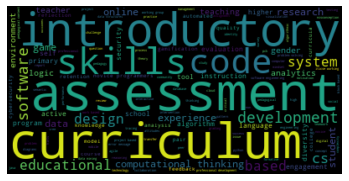

In [14]:
ignore = ['programming', 'education', 'learning', 'computer', 'science', 'computing', 'student', 'cs1']
all_tags = ' '.join(t.lower() for t in papers.tags.sum())
all_tags = ' '.join(w for w in all_tags.split() if w not in ignore)
wordcloud = WordCloud().generate(all_tags)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
pass